In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd  /content/drive/MyDrive/handwriting sign

/content/drive/MyDrive/handwriting sign


<ipython-input-3-c2cc4e2c91a8>:20: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),


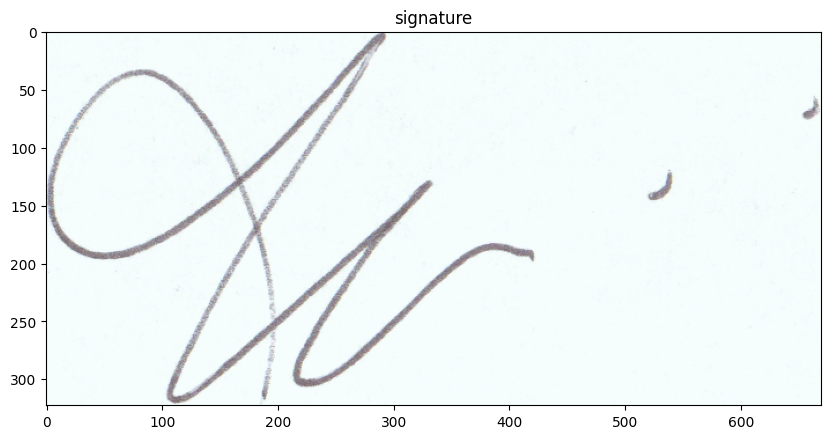

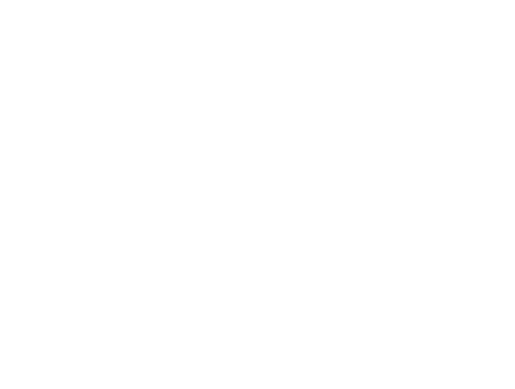

In [3]:

from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure, img_as_ubyte
import matplotlib.pyplot as plt
import os
fig = plt.figure(figsize=(10, 7))
row = 2

# Function to process and save HOG features for an image
def process_and_save_hog(image_path, save_path):
    # Reading the image
    img = imread(image_path)


    # Resizing the image
    resized_img = resize(img, (128 * 4, 64 * 4))

    # Extracting HOG features
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                        visualize=True, multichannel=True)

    # Convert HOG image to unsigned byte format
    hog_image = img_as_ubyte(hog_image)

    # Saving the HOG image
    imsave(save_path, hog_image)

    plt.imshow(img)
    plt.title("signature")
    plt.show()
    plt.axis('off')
# Specify the directory containing your input images
# Specify the directory where you want to save the HOG image
output_dir = 'Data'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Specify the path of your single input image
input_path = '/content/drive/MyDrive/handwriting sign/Officer signatures/REAL/01_049.png'

# Generate the output path for the HOG image
output_path = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(input_path))[0]}_hog.jpg")

# Process and save HOG features for the single image
process_and_save_hog(input_path, output_path)

1/1 [==============================] - 3s 3s/step
[[5.526737e-06 9.999945e-01]]
The Signature is: REAL
Success


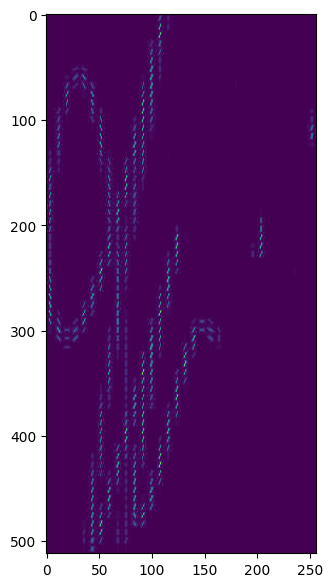

In [4]:
import cv2
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as img

UPLOAD_FOLDER = 'static/uploader/'
SIZE = 64  # Update the SIZE to match the expected input shape

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/handwriting sign/model/model_hog.h5')
categories = ["FAKE", "REAL"]

def upload_image(file_path):
    nimage = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(nimage, (SIZE, SIZE))  # Resize the image to (64, 64)
    image = image / 255.0
    prediction = model.predict(np.array(image).reshape(-1, SIZE, SIZE, 1))
    pclass = np.argmax(prediction)
    print(prediction)
    pValue = "The Signature is: {0}".format(categories[int(pclass)])
    print(pValue)
    realvalue = "Real Value 1"
    print('Success')

# Example usage
image_path ='/content/drive/MyDrive/handwriting sign/Data/01_049_hog.jpg'
upload_image(image_path)
plt.figure(figsize=(7, 7))
plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import cv2
import random

categories = ['FAKE', 'REAL']
TIME_STEPS = 31
IMG_HEIGHT = 64
IMG_WIDTH = 64

def createRCNNModel(input_shape):
    if os.path.exists('hogrcnn.h5'):
        try:
            print(__name__)
            model = keras.models.load_model('model_hogrcnn.h5')
            print("Model loaded successfully.")
            return model
        except (OSError, IOError, ValueError) as e:
            print(f"Error loading model: {e}")
    else:
        model = keras.Sequential([
            layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Reshape((TIME_STEPS, -1)),  # Reshape for LSTM input
            layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(2, activation="softmax")  # Assuming 2 classes (Fake and Real)
        ])
        return model

def getData():
    rawdata = []
    data = []
    dir = "/content/drive/MyDrive/handwriting sign/Data"
    for category in categories:
        path = os.path.join(dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                rawdata = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_data = cv2.resize(rawdata, (IMG_WIDTH, IMG_HEIGHT))
                data.append([new_data, class_num])
            except Exception as e:
                pass

    random.shuffle(data)

    img_data = []
    img_labels = []
    for features, label in data:
        img_data.append(features)
        img_labels.append(label)
    img_data = np.array(img_data).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)  # Add channel dimension
    img_data = img_data / 255.0
    img_labels = np.array(img_labels)

    return img_data, img_labels

data, labels = getData()
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.20)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.10)

input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)
model = createRCNNModel(input_shape)

checkpoint = ModelCheckpoint(filepath='hogrcnn.h5', save_best_only=True, monitor='val_loss', mode='min')

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(train_data, train_labels, epochs=100, validation_data=(val_data, val_labels), callbacks=[checkpoint])

model.save('hogrcnn.h5')

Epoch 1/100
12/12 [==============================] - 32s 742ms/step - loss: 0.6930 - accuracy: 0.5528 - val_loss: 0.6838 - val_accuracy: 0.6000
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 5s 452ms/step - loss: 0.6386 - accuracy: 0.6306 - val_loss: 0.9704 - val_accuracy: 0.5000
Epoch 3/100
12/12 [==============================] - 6s 525ms/step - loss: 0.5512 - accuracy: 0.7250 - val_loss: 0.6813 - val_accuracy: 0.6750
Epoch 4/100
12/12 [==============================] - 4s 356ms/step - loss: 0.5813 - accuracy: 0.6917 - val_loss: 0.6457 - val_accuracy: 0.6500
Epoch 5/100
12/12 [==============================] - 4s 349ms/step - loss: 0.5323 - accuracy: 0.7750 - val_loss: 0.6613 - val_accuracy: 0.6500
Epoch 6/100
12/12 [==============================] - 7s 595ms/step - loss: 0.5077 - accuracy: 0.7444 - val_loss: 0.6067 - val_accuracy: 0.6750
Epoch 7/100
12/12 [==============================] - 5s 361ms/step - loss: 0.4633 - accuracy: 0.7778 - val_loss: 0.6277 - val_accuracy: 0.6750
Epoch 8/100
12/12 [==============================] - 5s 468ms/step - loss: 0.4672 - accuracy: 0.7833 - val_loss: 0.5559 - val_accuracy: 0.6750
Epoch 9/100